In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import shap

from treemind.algorithm import Explainer

from examples.examples_plot import (
    plot_scatter_chart,
    interaction_scatter_plot,
)

In [2]:
# Set the number of samples and seed
n_samples = 12000
np.random.seed(42)

# Generate initial features
feature_0 = np.random.chisquare(df=3, size=n_samples)  # Chi-square
feature_1 = np.random.normal(loc=2, scale=1.5, size=n_samples)  # Normal
feature_2 = np.random.uniform(low=-5, high=5, size=n_samples)  # Uniform
feature_3 = np.random.gamma(
    shape=2, scale=2, size=n_samples
)  # Gamma distribution for feature_3

# Transform features
transformed_0 = np.sin(feature_0 / 2) * np.exp(-feature_0 / 10)  # Damped oscillation
transformed_1 = np.where(
    feature_1 > 2, 2 + 0.2 * (feature_1 - 2), feature_1
)  # Linear with soft threshold
transformed_2 = 0.5 * feature_2 + 0.1 * feature_2**2  # Mild quadratic trend
transformed_3 = np.log1p(feature_3) * np.exp(
    -feature_3 / 5
)  # Log transformation with damping

# Create target variable with added noise
target = (
    (transformed_0 - transformed_1) ** 2
    + (transformed_2 - transformed_3) ** 2
    + np.random.normal(loc=0, scale=0.2, size=n_samples)
)

# Introduce outliers
outlier_idx = np.random.choice(n_samples, size=int(n_samples * 0.005), replace=False)
target[outlier_idx] += np.random.normal(loc=0, scale=3, size=len(outlier_idx))

# Create DataFrame
df = pd.DataFrame(
    {
        "feature_0": feature_0,
        "feature_1": feature_1,
        "feature_2": feature_2,
        "feature_3": feature_3,
        "target": target,
    }
)

# Split data into X and y
X = df.drop("target", axis=1).values
y = df["target"].values

In [3]:
# Train a LightGBM model
reg = LGBMRegressor(verbose=-1, n_estimators=200, num_leaves=50, learning_rate=0.02)
reg.fit(X, y)  #

LGBMRegressor(learning_rate=0.02, n_estimators=200, num_leaves=50, verbose=-1)

In [4]:
# Use treemind's Explainer to analyze the trained model
explainer = Explainer()
explainer(reg)

# # Use shap's TreeExplainer to analyze the trained model
shap_explainer = shap.TreeExplainer(reg)
shap_values = shap_explainer(X)
shap_interaction_values = shap_explainer.shap_interaction_values(X)

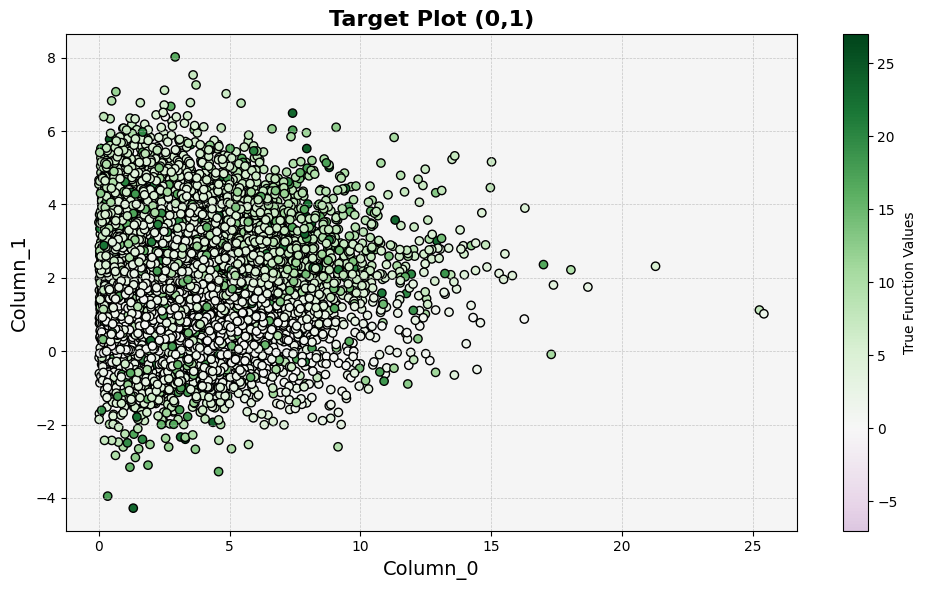

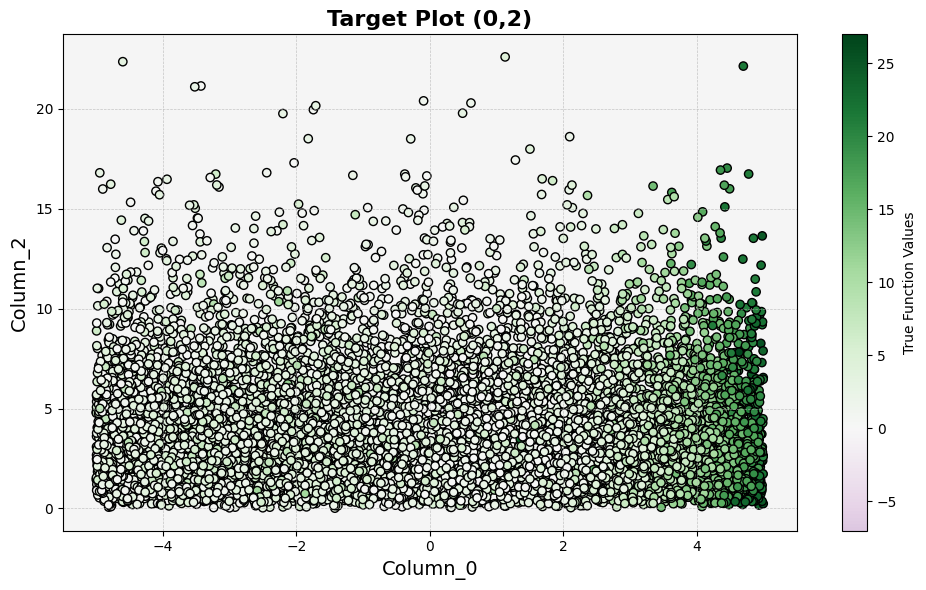

In [5]:
plot_scatter_chart(
    feature_0,
    feature_1,
    y,
    x_label="Column_0",
    y_label="Column_1",
    title="Target Plot (0,1)",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_2,
    feature_3,
    y,
    x_label="Column_0",
    y_label="Column_2",
    title="Target Plot (0,2)",
    cbar_label="True Function Values",
)

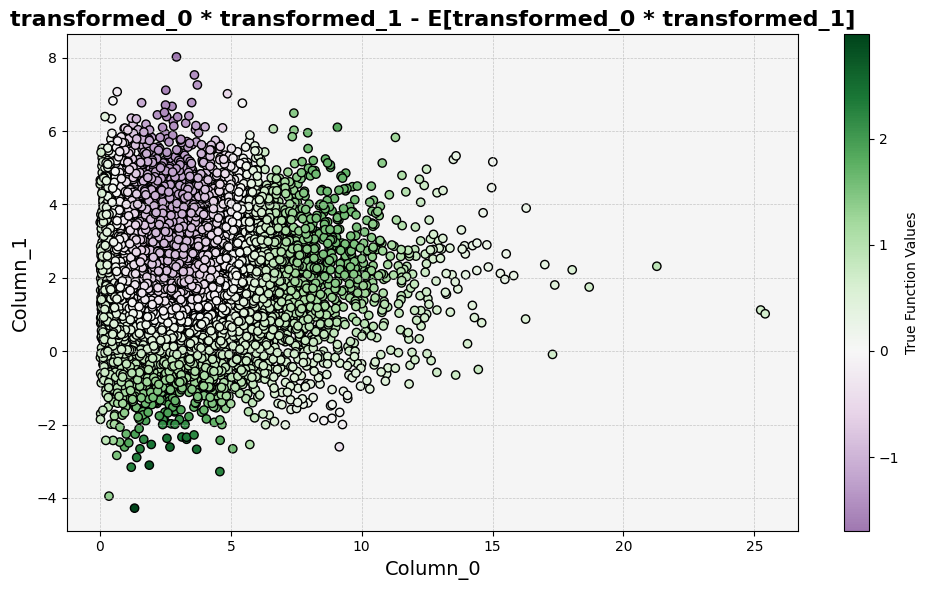

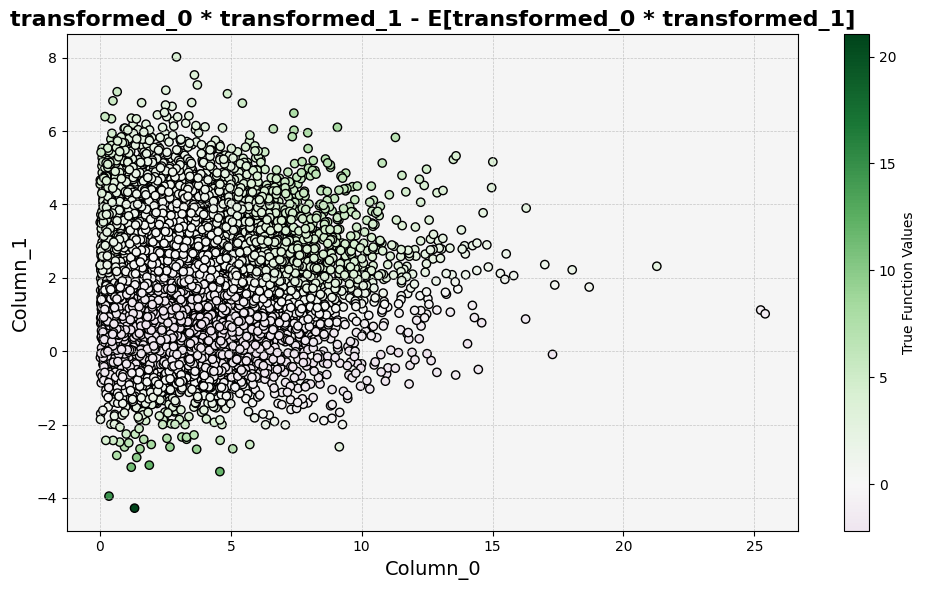

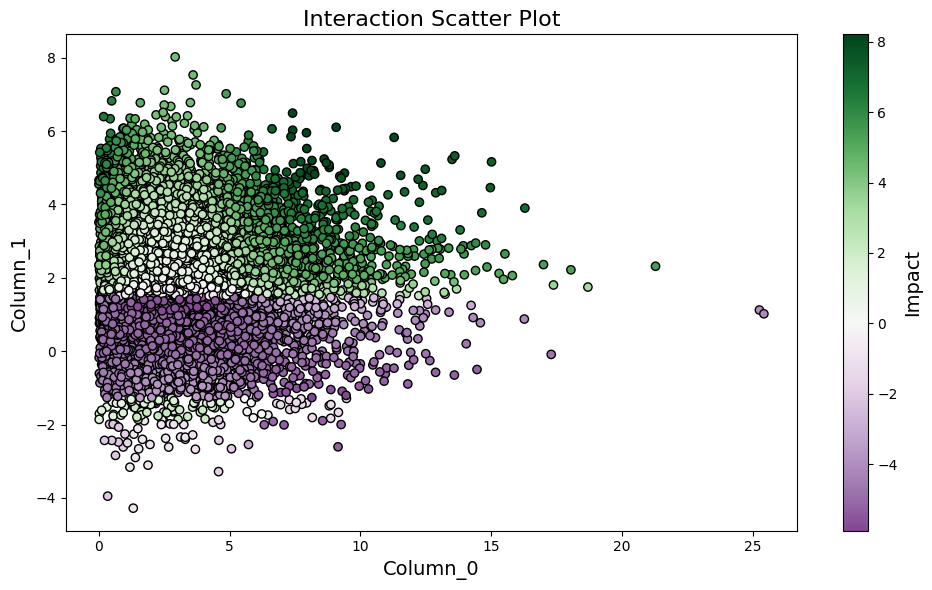

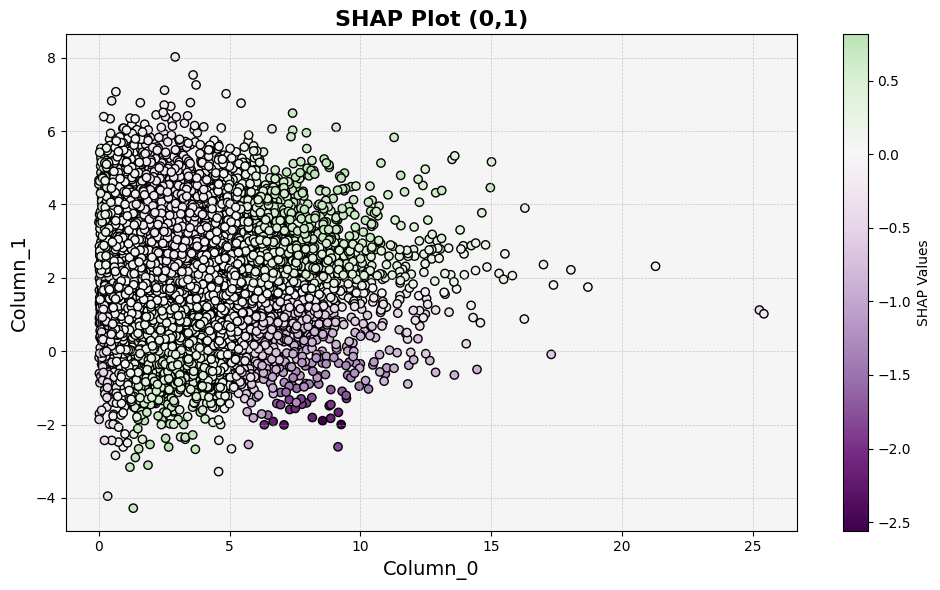

In [6]:
# Interaction Analysis: Feature 0 & Feature 1
df_01 = explainer.analyze_interaction(0, 1)

plot_scatter_chart(
    feature_0,
    feature_1,
    -transformed_0 * transformed_1
    - np.mean(-transformed_0 * transformed_1),
    x_label="Column_0",
    y_label="Column_1",
    title="transformed_0 * transformed_1 - E[transformed_0 * transformed_1]",
    cbar_label="True Function Values",
)


plot_scatter_chart(
    feature_0,
    feature_1,
    (transformed_0 - transformed_1)**2 - np.mean((transformed_0 - transformed_1)**2),
    x_label="Column_0",
    y_label="Column_1",
    title="transformed_0 * transformed_1 - E[transformed_0 * transformed_1]",
    cbar_label="True Function Values",
)


interaction_scatter_plot(X, df_01, 0, 1, figsize=(10, 6))

plot_scatter_chart(
    feature_0,
    feature_1,
    shap_interaction_values[:, 0, 1],
    x_label="Column_0",
    y_label="Column_1",
    title="SHAP Plot (0,1)",
    cbar_label="SHAP Values",
)

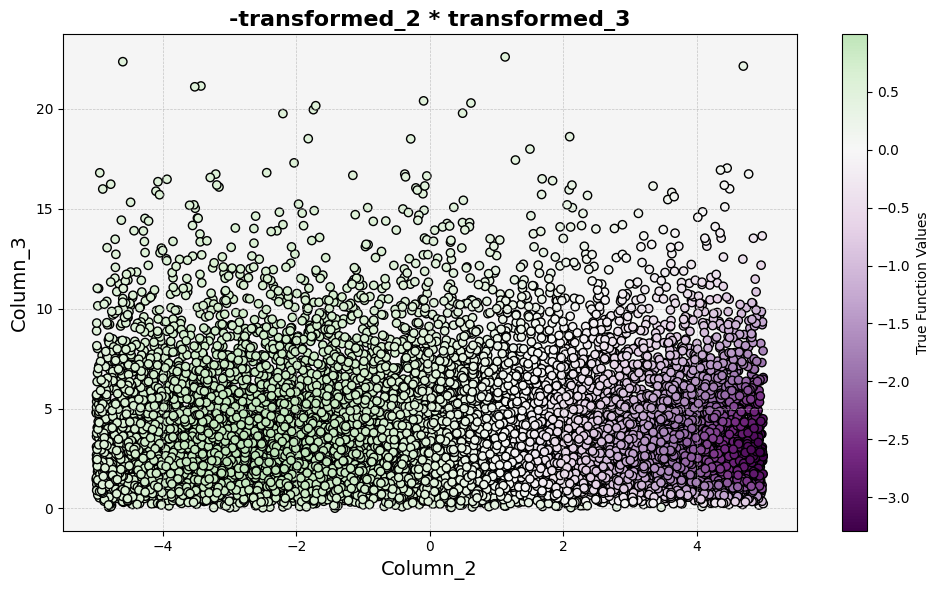

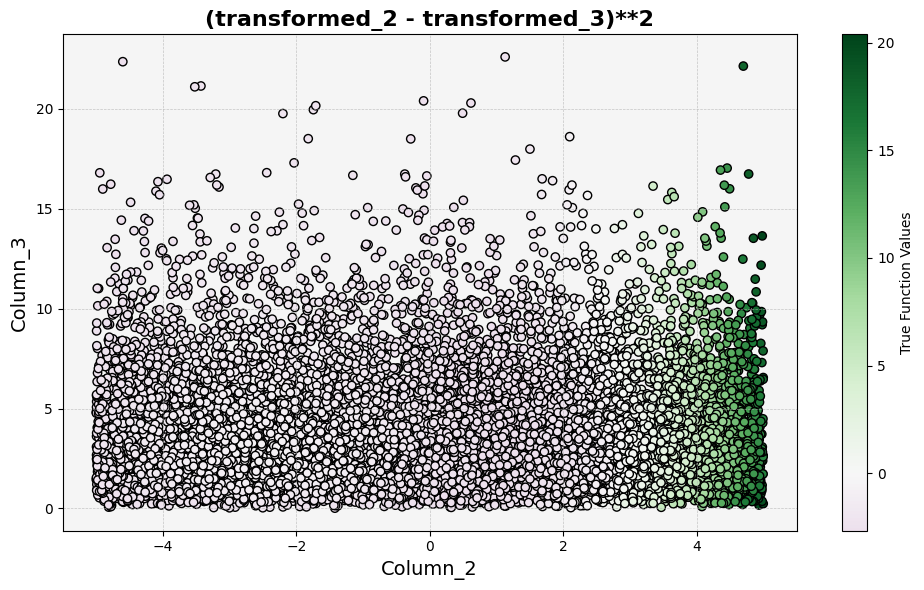

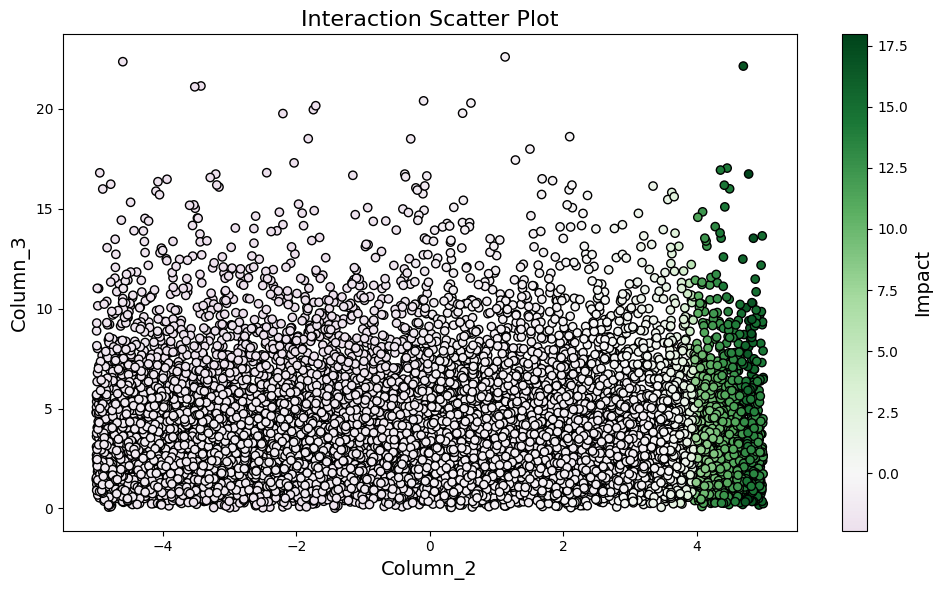

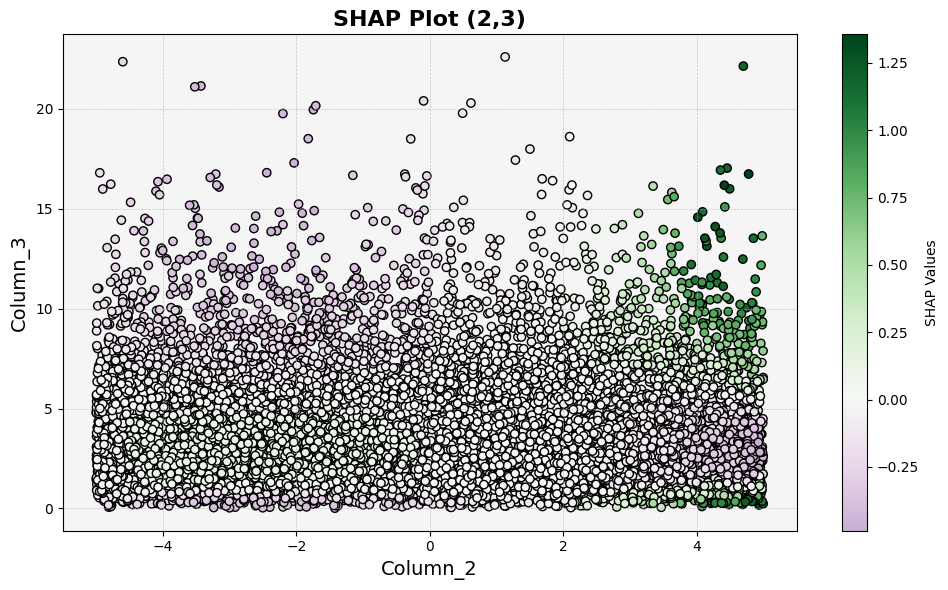

In [8]:
# Interaction Analysis: Feature 2 & Feature 3
plot_scatter_chart(
    feature_2,
    feature_3,
    -transformed_2 * transformed_3 - np.mean(-transformed_2 * transformed_3),
    x_label="Column_2",
    y_label="Column_3",
    title="-transformed_2 * transformed_3",
    cbar_label="True Function Values",
)

plot_scatter_chart(
    feature_2,
    feature_3,
    (transformed_2 - transformed_3)**2
    - np.mean((transformed_2 - transformed_3)**2),
    x_label="Column_2",
    y_label="Column_3",
    title="(transformed_2 - transformed_3)**2",
    cbar_label="True Function Values",
)


df_02 = explainer.analyze_interaction(2, 3)

interaction_scatter_plot(X, df_02, 2, 3, figsize=(10, 6))

plot_scatter_chart(
    feature_2,
    feature_3,
    shap_interaction_values[:, 2, 3],
    x_label="Column_2",
    y_label="Column_3",
    title="SHAP Plot (2,3)",
    cbar_label="SHAP Values",
)